In [1]:
import torch as tc
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np

from functions import LMF, MF, NMF, PMF, ALS, recommend_movies

In [2]:
# pass in column names for each CSV
u_cols = ['User_ID', 'Age', 'Sex', 'Occupation', 'Zip_Code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users.drop(columns=['Zip_Code'])

r_cols = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings = ratings.drop(columns=['Timestamp'])

m_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'Imdb_URL']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')
movies = movies.drop(columns=['Video_Release_Date', 'Imdb_URL'])

## Create R Matrix and Mask Matrix

In [3]:
R_df = ratings.pivot(index = 'User_ID', columns ='Movie_ID', values = 'Rating').fillna(0)
R_nan_df = ratings.pivot(index = 'User_ID', columns ='Movie_ID', values = 'Rating')
R = R_df.values
R_nan = R_nan_df.values
M, N = R.shape
mask = np.ones((M, N))
present = np.ma.masked_where(R != 0, R)
mask[present.mask == False] = False

mask_tc = tc.Tensor(mask)
R_tc = tc.Tensor(R)
R_normalized = (R - 1) / 4
R_normalized[mask==False] = 0
R_normalized_tc = tc.Tensor(R_normalized)

b = np.nanmean(R_nan)
b_u = np.nanmean(R_nan - b, axis = 1).reshape(M,1)
b_i = np.nanmean(R_nan - b, axis = 0).reshape(1,N)
bias = b + b_u + b_i

R_bias = mask * (R - bias)
R_bias_tc = tc.Tensor(R_bias)

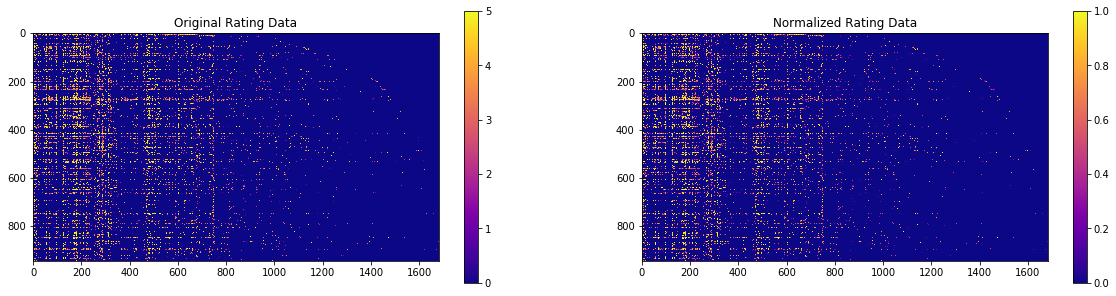

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(R, cmap='plasma',vmax=5,vmin=0)
plt.title('Original Rating Data')
plt.colorbar()
plt.subplot(122)
plt.imshow(R_normalized, cmap='plasma', vmax=1,vmin=0)  
plt.title('Normalized Rating Data')
plt.colorbar()
plt.show()

## Logistic Matrix Factorization

In [5]:
rank = 10
lmf = LMF(R_normalized_tc, mask_tc, rank, eta=0.005, nu=0.1, momentum=0.9, MAX_ITER=2000)
lmf.train()

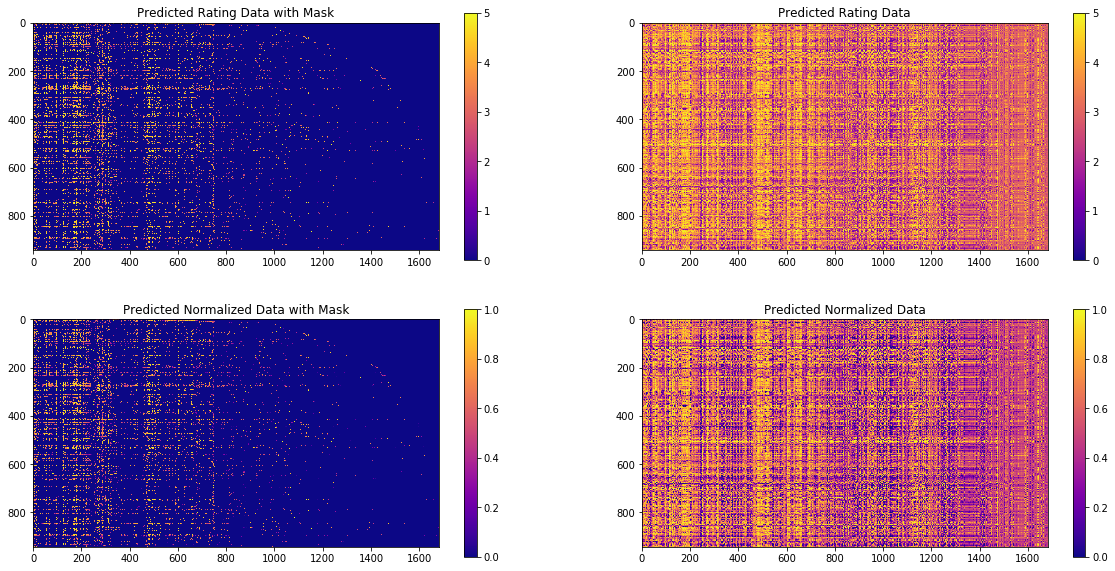

RMSE Error
0.6713589405739901
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                             Title Release_Date
289        319   Everyone Says I Love You (1996)  06-Dec-1996
681        718     In the Bleak Midwinter (1995)  23-Feb-1996
1106      1153                   Backbeat (1993)  01-Jan-1993
313        344               Apostle, The (1997)  18-Dec-1997
1113      1160  Love! Valour! Compassion! (1997)  16-May-1997
377        408             Close Shave, A (1995)  28-Apr-1996
244        262      In the Company of Men (1997)  01-Aug-1997
857        898               Postman, The (1997)  01-Jan-1997
162        173        Princess Bride, The (1987)  01-Jan-1987
452        485               My Fair Lady (1964)  01-Jan-1964

In [6]:
normalized_pred_tc = lmf.prediction
normalized_prediction = normalized_pred_tc.detach().numpy()
masked_normalized_prediction = mask * normalized_prediction
prediction = 4 * normalized_prediction + 1
masked_prediction = mask * prediction

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(223)
plt.imshow(masked_normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data with Mask')
plt.colorbar()

plt.subplot(222)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.subplot(224)
plt.imshow(normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Matrix Factorization

In [7]:
rank = 10
mf = MF(R_bias_tc, mask_tc, rank, eta=0.001, nu=0.1, momentum=0.9, MAX_ITER=2000)
mf.train()

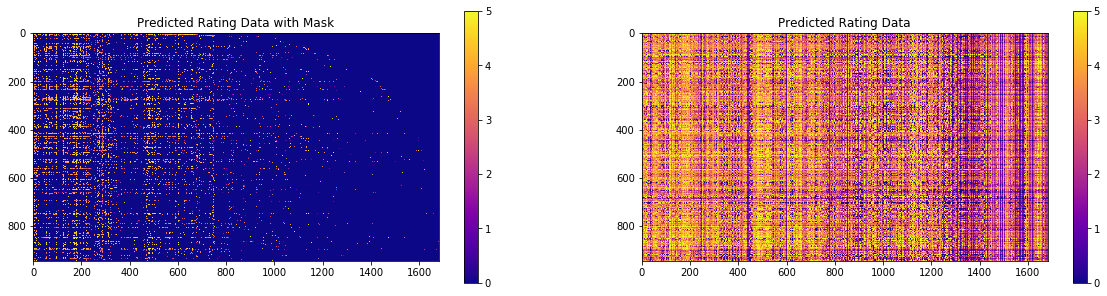

RMSE Error
0.6764861641003976
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                            Title Release_Date
771        811  Thirty-Two Short Films About Glenn Gould (1993)  01-Jan-1993
433        464                      Vanya on 42nd Street (1994)  01-Jan-1994
1112      1159                                   Stalker (1979)  01-Jan-1979
1234      1281                                Manny & Lo (1996)  26-Jul-1996
311        342              Man Who Knew Too Little, The (1997)  01-Jan-1997
1236      1283                                Out to Sea (1997)  04-Jul-1997
1038      1085                              Carried Away (1996)  29-Mar-1996
467        500                             Fly Away Home (1996)  13-Sep-1996
645        681                                Wishmaster (1997)  01-Jan-1997
902        945                                   Charade (1963)  01-Jan-1963

In [8]:
prediction_tc = mf.prediction
prediction = prediction_tc.detach().numpy() + bias
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Probabilistic Matrix Factorization

In [41]:
R_samples = [
            (i, j, R[i, j])
            for i in range(M)
            for j in range(N)
            if R[i, j] > 0
        ]
R_samples = np.array(R_samples)

In [46]:
pmf = PMF()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.9, "maxepoch": 40, "num_batches": 100, "batch_size": 1000})
#train, test = train_test_split(R_samples, test_size=0.2)
train = R_samples
test = R_samples
pmf.train(train, test)

Training RMSE: 1.122678, Test RMSE 1.122678
Training RMSE: 1.116165, Test RMSE 1.116165
Training RMSE: 1.078939, Test RMSE 1.078939
Training RMSE: 0.989712, Test RMSE 0.989712
Training RMSE: 0.929450, Test RMSE 0.929450
Training RMSE: 0.893631, Test RMSE 0.893631
Training RMSE: 0.869743, Test RMSE 0.869743
Training RMSE: 0.851959, Test RMSE 0.851959
Training RMSE: 0.837443, Test RMSE 0.837443
Training RMSE: 0.824207, Test RMSE 0.824207
Training RMSE: 0.813491, Test RMSE 0.813491
Training RMSE: 0.803589, Test RMSE 0.803589
Training RMSE: 0.795682, Test RMSE 0.795682
Training RMSE: 0.788424, Test RMSE 0.788424
Training RMSE: 0.781713, Test RMSE 0.781713
Training RMSE: 0.777024, Test RMSE 0.777024
Training RMSE: 0.772311, Test RMSE 0.772311
Training RMSE: 0.768795, Test RMSE 0.768795
Training RMSE: 0.764948, Test RMSE 0.764948
Training RMSE: 0.762165, Test RMSE 0.762165
Training RMSE: 0.759262, Test RMSE 0.759262
Training RMSE: 0.757031, Test RMSE 0.757031
Training RMSE: 0.755368, Test RM

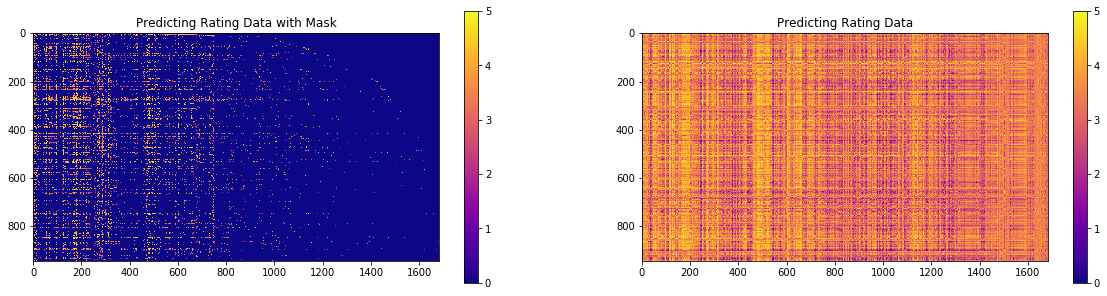

RMSE Error
0.7374303217157238


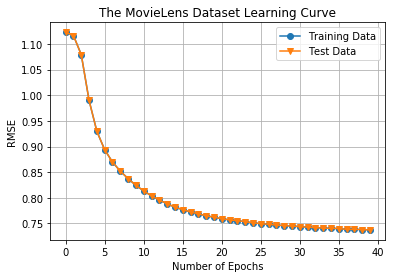

precision_acc,recall_acc:(0.18494167550371096, 0.018328326398743273)
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                              Title Release_Date
105       114  Wallace & Gromit: The Best of Aardman Animatio...  05-Apr-1996
509       543                             Misérables, Les (1995)  01-Jan-1995
313       344                                Apostle, The (1997)  18-Dec-1997
49         57                                      Priest (1994)  01-Jan-1994
661       697                     Basketball Diaries, The (1995)  01-Jan-1995
681       718                      In the Bleak Midwinter (1995)  23-Feb-1996
578       613                              My Man Godfrey (1936)  01-Jan-1936
496       529        My Life as a Dog (Mitt liv som hund) (1985)  01-Jan-1985
450       483                                  Casablanca (1942)  01-Jan-1942
104       113  Horseman on the Roof, The (Hussard sur le toit...  19-Apr-1996

In [47]:
prediction = pmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

# Check performance by plotting train and test errors
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("precision_acc,recall_acc:" + str(pmf.topK(test)))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Nonnegative Matrix Factorization

In [12]:
rank = 10
nmf = NMF(R, mask, rank, MAX_ITER=2000)
nmf.train()

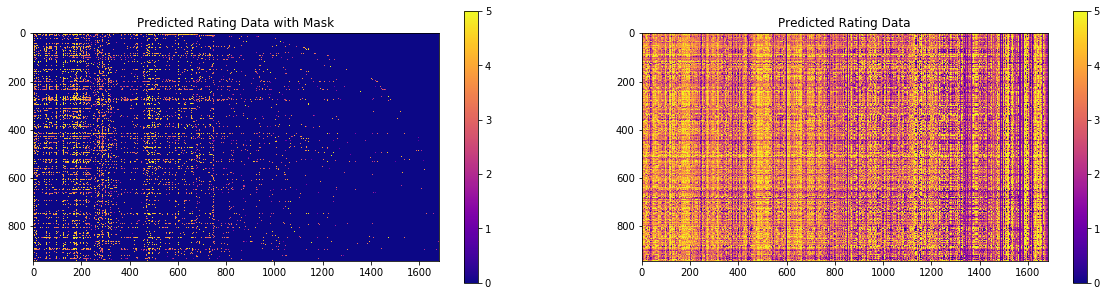

RMSE Error
0.7145803083428934
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                           Title Release_Date
1444      1491         Tough and Deadly (1995)  01-Jan-1995
748        788            Relative Fear (1994)  01-Jan-1994
1257      1304             New York Cop (1996)  01-Jan-1996
1246      1293                 Star Kid (1997)  16-Jan-1998
1117      1164         Zeus and Roxanne (1997)  10-Jan-1997
1584      1631           Slingshot, The (1993)  01-Jan-1993
1087      1134           Get on the Bus (1996)  16-Oct-1996
1615      1662              Rough Magic (1995)  30-May-1997
1209      1256  Designated Mourner, The (1997)  23-May-1997
955        999              Clean Slate (1994)  01-Jan-1994

In [13]:
prediction = nmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## Alternating Least Squares

In [14]:
rank = 10
lambda_ = 0.1
als = ALS(R, mask, rank, lambda_, MAX_ITER=10)
als.train()

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed


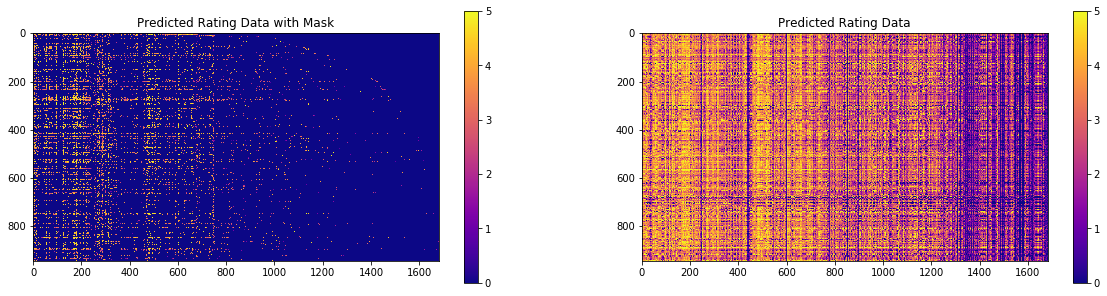

RMSE Error
0.6961882630772432
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                              Title Release_Date
452        485                                My Fair Lady (1964)  01-Jan-1964
1073      1120                           I'm Not Rappaport (1996)  13-Nov-1996
133        143                         Sound of Music, The (1965)  01-Jan-1965
1106      1153                                    Backbeat (1993)  01-Jan-1993
1090      1137                             Beautiful Thing (1996)  09-Oct-1996
428        459                    Cry, the Beloved Country (1995)  01-Jan-1995
602        638  Return of Martin Guerre, The (Retour de Martin...  01-Jan-1982
868        909                            Dangerous Beauty (1998)  23-Jan-1998
377        408                              Close Shave, A (1995)  28-Apr-1996
1013      1060                Adventures of Pinocchio, The (1996)  26-Jul-1996

In [15]:
prediction = als.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

## SVD

In [16]:
U, sigma, Vt = svds(R_bias, k = 10)
sigma = np.diag(sigma)

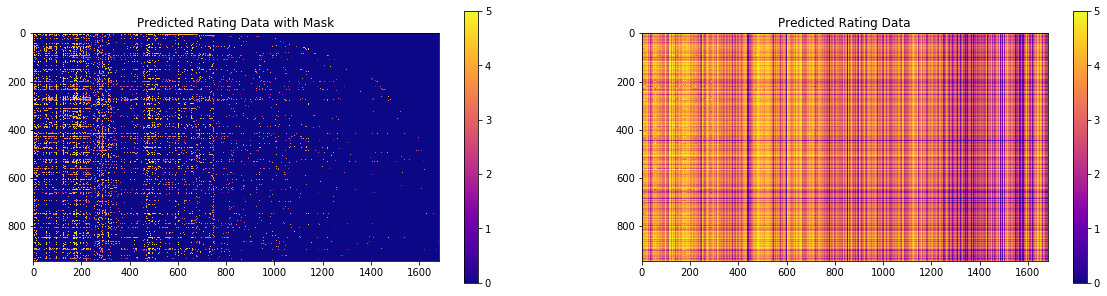

RMSE Error
0.8495749887047357
User 837 has already rated 46 movies.
Recommending the highest 10 predicted ratings movies not already rated.


Movie_ID                                              Title Release_Date
1154      1201         Marlene Dietrich: Shadow and Light (1996)   02-Apr-1996
1246      1293                                    Star Kid (1997)  16-Jan-1998
1075      1122                     They Made Me a Criminal (1939)  01-Jan-1939
1606      1653  Entertaining Angels: The Dorothy Day Story (1996)  27-Sep-1996
1489      1536                               Aiqing wansui (1994)  22-Jul-1996
1420      1467               Saint of Fort Washington, The (1993)  01-Jan-1993
1552      1599                      Someone Else's America (1995)  10-May-1996
1453      1500                          Santa with Muscles (1996)  08-Nov-1996
1142      1189                                 Prefontaine (1997)  24-Jan-1997
774        814                      Great Day in Harlem, A (1994)  01-Jan-1994

In [17]:
prediction = np.dot(np.dot(U, sigma), Vt) + bias
masked_prediction = mask * prediction

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)/100000))

prediction_df = pd.DataFrame(prediction, columns = R_df.columns)
already_rated, predictions = recommend_movies(prediction_df, 837, movies, ratings, 10)
predictions

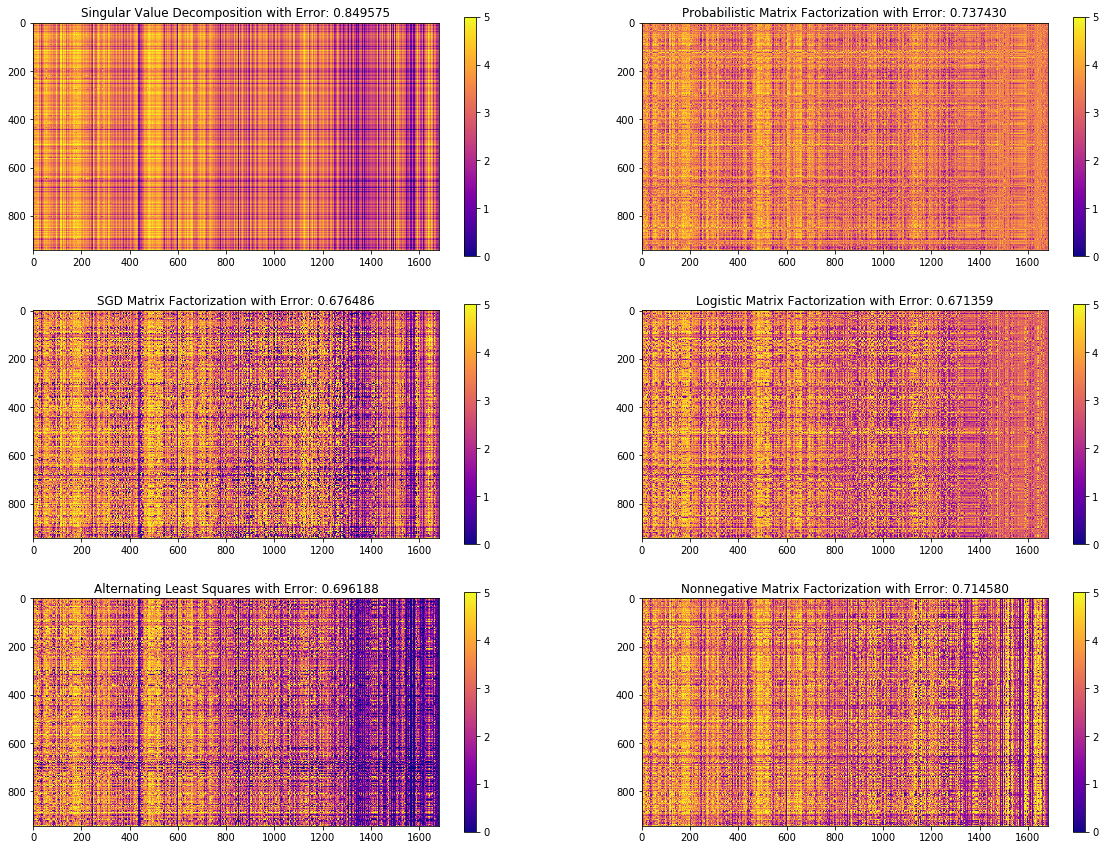

In [51]:
plt.figure(figsize=(20,15))

prediction = np.dot(np.dot(U, sigma), Vt) + bias
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(321)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Singular Value Decomposition with Error: %f' % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()

prediction = pmf.prediction
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(322)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Probabilistic Matrix Factorization with Error: %f'  % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()

prediction_tc = mf.prediction
prediction = prediction_tc.detach().numpy() + bias
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(323)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('SGD Matrix Factorization with Error: %f'  % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()

normalized_pred_tc = lmf.prediction
normalized_prediction = normalized_pred_tc.detach().numpy()
prediction = 4 * normalized_prediction + 1
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(324)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Logistic Matrix Factorization with Error: %f' % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()

prediction = als.prediction
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(325)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Alternating Least Squares with Error: %f' % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()

prediction = nmf.prediction
masked_prediction = mask * prediction
E = R - masked_prediction
plt.subplot(326)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Nonnegative Matrix Factorization with Error: %f' % (np.sqrt(np.sum(E**2)/100000)))
plt.colorbar()
plt.show()

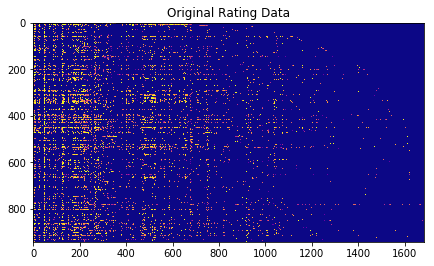

In [40]:
plt.figure(figsize=(7,8))
plt.imshow(R, cmap='plasma',vmax=5,vmin=0)
plt.title('Original Rating Data')
#plt.colorbar()
plt.show()